2018 Sep 11 <br>
I still seem to be having problems with fitting transits that are binned. Here I will generate some synthetic transits, bin them, and then check whether I can recover them.

In [7]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from copy import deepcopy

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from PyAstronomy.modelSuite import forTrans as ft
from PyAstronomy.pyasl import isInTransit

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import median_boxcar_filter, bindata, transit_duration, flag_outliers, fit_eclipse_bottom
from variable_eclipses_utils import retreive_data

KIC = 4570949
#dill.load_session('Analysis_of_Kepler76b.db')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# The system parameters as reported in Faigler et al. (2013) --
#  http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta
a = 1./0.221 #± 0.003
b = 0.944 # ± 0.011
inc = 78.0 # ± 0.2
per = 1.54492875*u.day # ± 0.00000027
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s) # convert to fraction of the speed of light

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*a
Ms = 1.2*u.solMass # ± 0.2
q = (Mp.to('kg')/Ms.to('kg')).value

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
Omegas = vsini.to('m/s')/Rs.to('m')*per.to('s') # stellar rotation state - very little effect, so chosen arbitrarily

Ts = 6300. # ± 200
Faigler_T0 = (737.49 + 2455000. - 2454833.) % per.to('day').value # ±0.19
T0 = 0.68508434

coeffs = [0.313, 0.304]

Aplanet = 60.4e-6 # ± 2.0
F0 = 60.4e-6 # ± 2.0 -- overall shift in light curve, which is arbitrary
phase_shift = -10.3/360. # ± 2.0 - convert phase shift angle from degrees to orbital phase

beta = 0.0716671 # Interpolation from among the values reported in Claret & Bloemen (2011) A&A 529, 75

# Save parameters to an evilmc parameters object
saved_ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
                    F0=F0, Aplanet=Aplanet, phase_shift=phase_shift, beta=beta, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
                    u=coeffs)

In [4]:
num_period = 1
binsize = 30./60./24.

# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(saved_ep.per, num_periods=num_period, 
                                                         KIC=KIC, fit_bottom=True, params=saved_ep)
folded_time = filtered_time % saved_ep.per

binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, binsize=binsize)

In [80]:
def make_transit(time, cur_T0, cur_semi, cur_p, cur_inc, supersample_factor=100, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")
    
    # Set parameters
    model["per"] = saved_ep.per
    model["i"] = cur_inc
    model["a"] = cur_semi
    model["T0"] = cur_T0
    model["p"] = cur_p
    model["linLimb"] = saved_ep.u[0]
    model["quadLimb"] = saved_ep.u[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

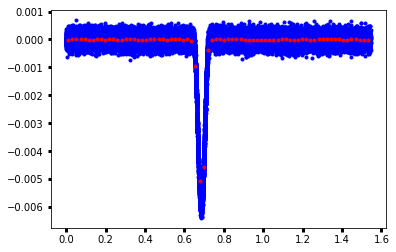

In [83]:
unbinned_noise = 170e-6 # based on Analysis_of_Kepler76b.ipynb as of 2018 Sep 11

synthetic_transit = make_transit(folded_time, saved_ep.T0, saved_ep.a, saved_ep.p, inc)
noisy_synthetic_transit = synthetic_transit + normal(size=synthetic_transit.size, scale=unbinned_noise)

binned_time_synthetic_transit, noisy_binned_synthetic_transit, binned_err_synthetic_transit =\
    bindata(folded_time, noisy_synthetic_transit, binsize=binsize)

plt.plot(folded_time, noisy_synthetic_transit, 'b.')
plt.plot(binned_time_synthetic_transit, noisy_binned_synthetic_transit, 'r.')

[0.7, 4.524886877828054, 0.1, 80.0]
[ 0.68507521  4.55062633  0.095692   78.10060965]
[1.93954213e-05 4.43855914e-02 2.19998416e-03 1.80537688e-01]
135.70487719338726


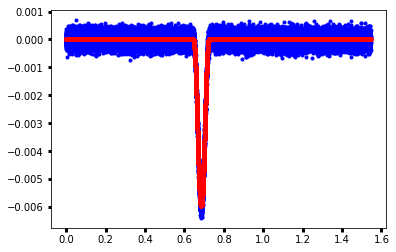

In [85]:
# Fitting the unbinned transit
time = folded_time
data = noisy_synthetic_transit

initial_guess = [0.7, a, 0.1, 80.]
trans_popt, trans_pcov = curve_fit(make_transit, time, data, sigma=unbinned_noise*np.ones_like(time),
                       p0=initial_guess,
                       bounds=([Faigler_T0 - 0.2, 2., 0., 70.], 
                               [Faigler_T0 + 0.2, 5., 0.2, 100.]))
print(initial_guess)
print(trans_popt)
print(np.sqrt(trans_pcov.diagonal()))

plt.plot(time, data, 'b.')
plt.plot(time, make_transit(time, *trans_popt), 'r.')

resid = data - make_transit(time, *trans_popt)
print(np.mean(np.abs(resid))*1e6)

(0.68508434, 4.524886877828054, 0.09683257918552035, 78.0)
[0.7, 4.524886877828054, 0.1, 80.0]
[ 0.68552111  4.89059505  0.07991578 79.47494804]
[3.20613092e-05 6.41063122e-02 5.82419172e-04 1.90815701e-01]
-0.7253553718029595


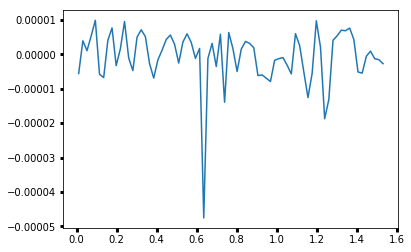

In [86]:
# Fitting the binned transit
time = binned_time_synthetic_transit
data = noisy_binned_synthetic_transit
initial_guess = [0.7, a, 0.1, 80.]
trans_popt, trans_pcov = curve_fit(make_transit, time, data,
                       p0=initial_guess,
                       bounds=([Faigler_T0 - 0.2, 2., 0., 70.], 
                               [Faigler_T0 + 0.2, 6., 0.2, 100.]))
print(saved_ep.T0, saved_ep.a, saved_ep.p, inc)
print(initial_guess)
print(trans_popt)
print(np.sqrt(trans_pcov.diagonal()))

# plt.plot(time, data, 'b.')
# plt.plot(time, make_transit(time, *trans_popt), 'r.')

resid = data - make_transit(time, *trans_popt)
plt.plot(time, resid)
print(np.mean(resid)*1e6)

In [74]:
# Just for the heck of it, let's try a different bin size
binsize = 1./60./24.

binned_time_synthetic_transit, noisy_binned_synthetic_transit, binned_err_synthetic_transit =\
    bindata(folded_time, noisy_synthetic_transit, binsize=binsize)

(0.68508434, 4.524886877828054, 0.09683257918552035, 78.0)
[0.7, 4.524886877828054, 0.1, 80.0]
[ 0.6850549   6.          0.08456197 81.6732622 ]
[2.04798746e-05 6.33692221e-02 2.87899228e-04 1.20810904e-01]
0.9940381379354275


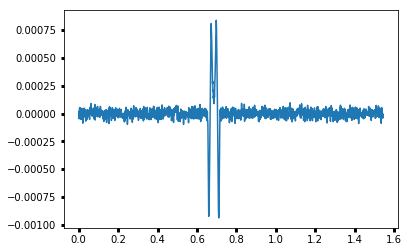

In [75]:
# Fitting the binned transit
time = binned_time_synthetic_transit
data = noisy_binned_synthetic_transit
initial_guess = [0.7, a, 0.1, 80.]
trans_popt, trans_pcov = curve_fit(make_transit_supersample, time, data,
                       p0=initial_guess,
                       bounds=([Faigler_T0 - 0.2, 2., 0., 70.], 
                               [Faigler_T0 + 0.2, 6., 0.2, 100.]))
print(saved_ep.T0, saved_ep.a, saved_ep.p, inc)
print(initial_guess)
print(trans_popt)
print(np.sqrt(trans_pcov.diagonal()))

# plt.plot(time, data, 'b.')
# plt.plot(time, make_transit(time, *trans_popt), 'r.')

resid = data - make_transit(time, *trans_popt)
plt.plot(time, resid)
print(np.mean(resid)*1e6)

Without doubt, the conclusion is that I cannot fit the transit if I bin it!

In [76]:
# Let's see how long it takes to run EVIL-MC for the full dataset
em = evmodel(folded_time, saved_ep, supersample_factor=10, exp_time=30./60./24.)
%time sig = em.all_signals()

CPU times: user 1min 12s, sys: 1min 31s, total: 2min 44s
Wall time: 3min 5s


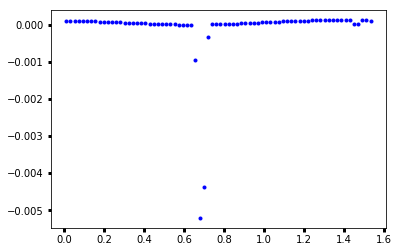

In [8]:
em = evmodel(binned_time, saved_ep, supersample_factor=10, exp_time=30./60./24.)
sig = em.all_signals()

plt.plot(binned_time, sig, 'b.')

---

2018 Sep 17<br>
Next, I'm going to explore how accurately I can recover an eclipse depth when I take a certain super-sample factor.

In [7]:
def make_eclipse(time, cur_TE, cur_semi, cur_p, cur_inc, cur_depth, supersample_factor=100, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")
    
    # Set parameters
    model["per"] = saved_ep.per
    model["i"] = cur_inc
    model["a"] = cur_semi
    model["T0"] = cur_TE - 0.5*saved_ep.per
    model["p"] = cur_p
    model["linLimb"] = saved_ep.u[0]
    model["quadLimb"] = saved_ep.u[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

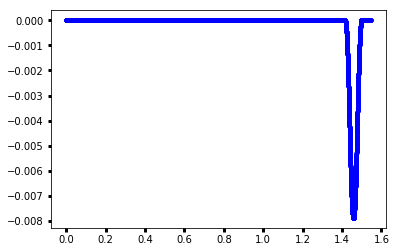

In [9]:
unbinned_noise = 170e-6 # based on Analysis_of_Kepler76b.ipynb as of 2018 Sep 11

# Let's see how long it takes to run EVIL-MC for the full dataset
ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
              F0=F0, Aplanet=Aplanet, phase_shift=phase_shift, beta=beta, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
              u=coeffs)
em = evmodel(filtered_time, ep, supersample_factor=10, exp_time=30./60./24.)
sig = em.calc_eclipse(0.01)

plt.plot(folded_time, sig, 'b.')

# Take only the eclipse portion
# TE = saved_ep.T0 + 0.5*saved_ep.per
# dur = transit_duration(saved_ep)
# ind = np.abs(folded_time - TE) < 2.*dur

# time = folded_time[ind]
# data = filtered_flux[ind]

# synthetic_eclipse = em.
# noisy_synthetic_eclipse = synthetic_eclipse + normal(size=synthetic_transit.size, scale=unbinned_noise)

# binned_time_synthetic_transit, noisy_binned_synthetic_transit, binned_err_synthetic_transit =\
#     bindata(folded_time, noisy_synthetic_transit, binsize=binsize)

# plt.plot(folded_time, noisy_synthetic_transit, 'b.')
# plt.plot(binned_time_synthetic_transit, noisy_binned_synthetic_transit, 'r.')